# COIN-OR

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import json
import math
import pulp
import pandas as pd
# conda install -c conda-forge highs

In [3]:
import time

In [5]:
basic_data_path = get_path("data", "basic")

In [6]:
# Datei laden
file_path = basic_data_path / "jobshop_instances.json"

with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [7]:
def solve_jssp_makespan(df_jssp: pd.DataFrame, solver: str = 'CBC', epsilon: float = 0.06, 
                        time_limit: int = 1200, **solver_args):
    """
    Minimiert den Makespan eines Job-Shop-Problems auf Basis eines DataFrames,
    mit dynamisch berechnetem Big-M statt statischem 1e5.

    Parameter:
    - df_jssp: DataFrame mit Spalten ['Job','Operation','Machine','Processing Time'].
    - solver:  'CBC' oder 'HiGHS' (case-insensitive).
    - time_limit: Zeitlimit für den Solver in Sekunden (Standard: 1200).
    - epsilon: Pufferzeit in Minuten zwischen zwei Jobs auf derselben Maschine.
    - **solver_args: Weitere Keyword-Argumente für den gewählten Solver.

    Rückgabe:
    - df_schedule: DataFrame mit Spalten
      ['Job','Operation','Machine','Start','Processing Time','End']
    - makespan_value: minimaler Makespan (float)
    """

    # 1) Index
    df = df_jssp.reset_index(drop=False).rename(columns={'index': 'Idx'}).copy()
    # df['OpIdx'] = df.groupby('Job')['Operation'].first()

    # Big-M berechnen
    sum_proc_time = df['Processing Time'].sum()
    bigM = math.ceil(sum_proc_time / 1000) * 1000 * 4

    #bigM = 1e5

    print(f"BigM: {bigM}")

    # 2) LP-Modell
    prob = pulp.LpProblem('JSSP', pulp.LpMinimize)
    starts = {
        idx: pulp.LpVariable(f'start_{idx}', lowBound=0, cat='Continuous')
        for idx in df['Idx']
    }
    makespan = pulp.LpVariable('makespan', lowBound=0, cat='Continuous')
    prob += makespan

    # 3) Reihenfolge je Job (technologische Abhängigkeiten)
    for job, group in df.groupby('Job', sort=False):
        seq = group.sort_values('Operation')
        for prev, curr in zip(seq['Idx'], seq['Idx'][1:]):
            dur_prev = df.loc[df['Idx'] == prev, 'Processing Time'].iat[0]
            prob += starts[curr] >= starts[prev] + dur_prev

    # 4) Maschinenkonflikte mit Big-M
    for _, group in df.groupby('Machine', sort=False):
        ids = group['Idx'].tolist()
        for i in range(len(ids)):
            for j in range(i + 1, len(ids)):
                i_idx, j_idx = ids[i], ids[j]
                if df.loc[df['Idx'] == i_idx, 'Job'].iat[0] == df.loc[df['Idx'] == j_idx, 'Job'].iat[0]:
                    continue
                di = df.loc[df['Idx'] == i_idx, 'Processing Time'].iat[0]
                dj = df.loc[df['Idx'] == j_idx, 'Processing Time'].iat[0]
                y = pulp.LpVariable(f'y_{i_idx}_{j_idx}', cat='Binary')
                prob += starts[i_idx] + di + epsilon <= starts[j_idx] + bigM * (1 - y)
                prob += starts[j_idx] + dj + epsilon <= starts[i_idx] + bigM * y

    # 5) Makespan-Constraints
    for _, row in df.iterrows():
        idx = int(row['Idx'])
        prob += starts[idx] + row['Processing Time'] <= makespan

    # 6) Solver vorbereiten
    solver_args.setdefault('timeLimit', time_limit)
    solver_args.setdefault('msg', True)

    solver = solver.upper()
    if solver in ['CBC', 'BRANCH AND CUT']:
        cmd = pulp.PULP_CBC_CMD(**solver_args)
    elif solver == 'HIGHS':
        cmd = pulp.HiGHS_CMD(**solver_args)
    else:
        raise ValueError("Solver must be 'CBC' or 'HiGHS'")

    prob.solve(cmd)
    makespan_value = pulp.value(prob.objective)

    # 7) Ergebnis aufbereiten
    df['Start'] = df['Idx'].map(lambda i: round(starts[i].varValue, 2))
    df['End'] = df['Start'] + df['Processing Time']
    df_schedule = df[['Job', 'Operation', 'Machine', 'Start', 'Processing Time', 'End']] \
        .sort_values(['Start', 'Job', 'Operation']) \
        .reset_index(drop=True)

    # 8) Logging
    print("\nSolver-Informationen:")
    print(f"  Zielfunktionswert       : {round(pulp.value(prob.objective), 4)}")
    print(f"  Solver-Status           : {pulp.LpStatus[prob.status]}")
    print(f"  Anzahl Variablen        : {len(prob.variables())}")
    print(f"  Anzahl Constraints      : {len(prob.constraints)}")

    return df_schedule


In [8]:
max_time = 60*60*6

### a) CBC - COIN-OR Branch and Cut

In [9]:
starting_time = time.time()

# Scheduling
df_plan = solve_jssp_makespan(df_instance, solver= "CBC", msg=False, time_limit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.1f} Sekunden.")
df_plan

BigM: 24000

Solver-Informationen:
  Zielfunktionswert       : 946.42
  Solver-Status           : Optimal
  Anzahl Variablen        : 551
  Anzahl Constraints      : 1090

Scheduling-Dauer: 360 Minuten und 3.6 Sekunden.


,Job,Operation,Machine,Start,Processing Time,End
0,job 3,0,M1,0.00,81,81.00
1,job 5,0,M2,0.00,84,84.00
2,job 8,0,M0,0.00,76,76.00
3,job 1,0,M0,76.06,43,119.06
4,job 5,1,M1,84.00,2,86.00
...,...,...,...,...,...,...
95,job 4,9,M6,868.48,53,921.48
96,job 9,9,M7,900.78,45,945.78
97,job 1,9,M8,910.72,30,940.72
98,job 2,9,M4,913.42,33,946.42


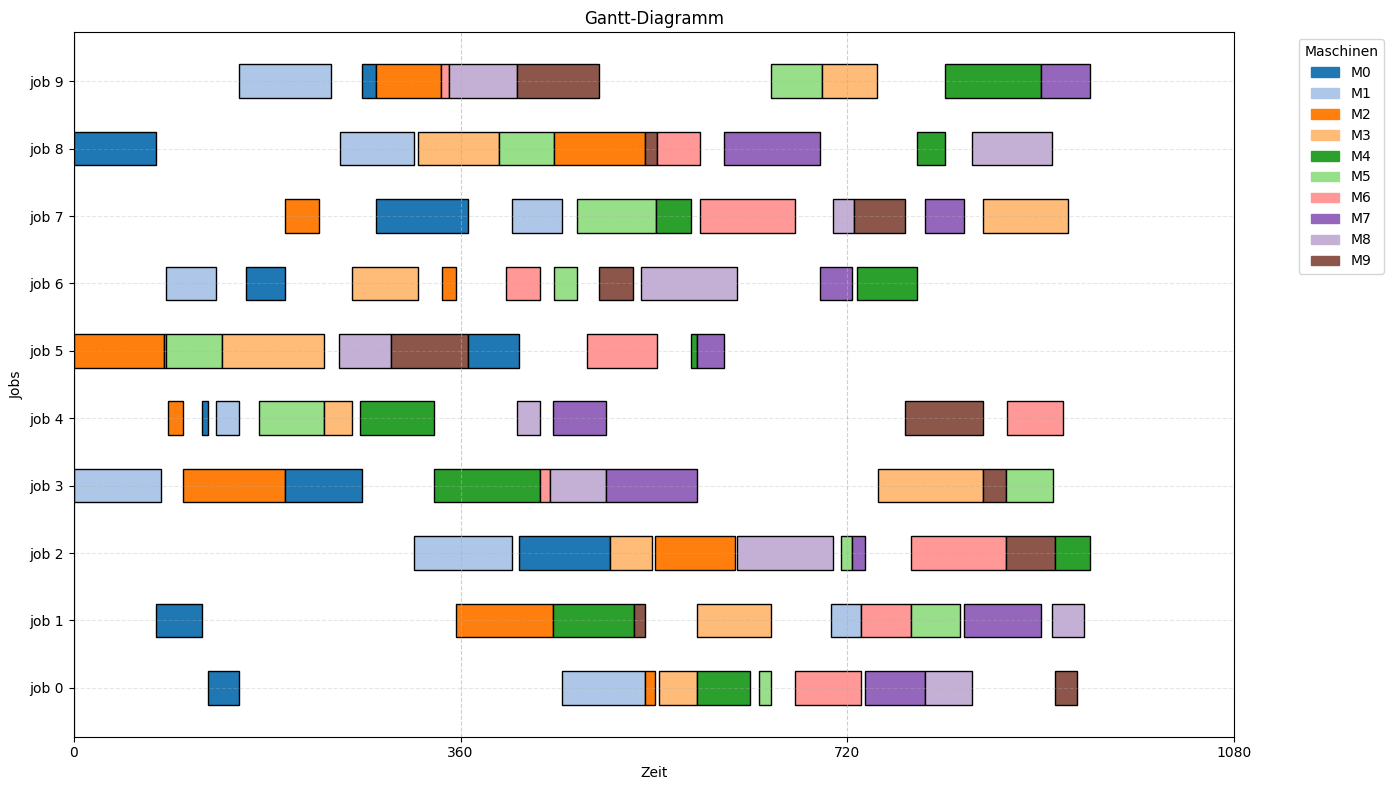

In [10]:
show.plot_gantt_jobs(df_plan)

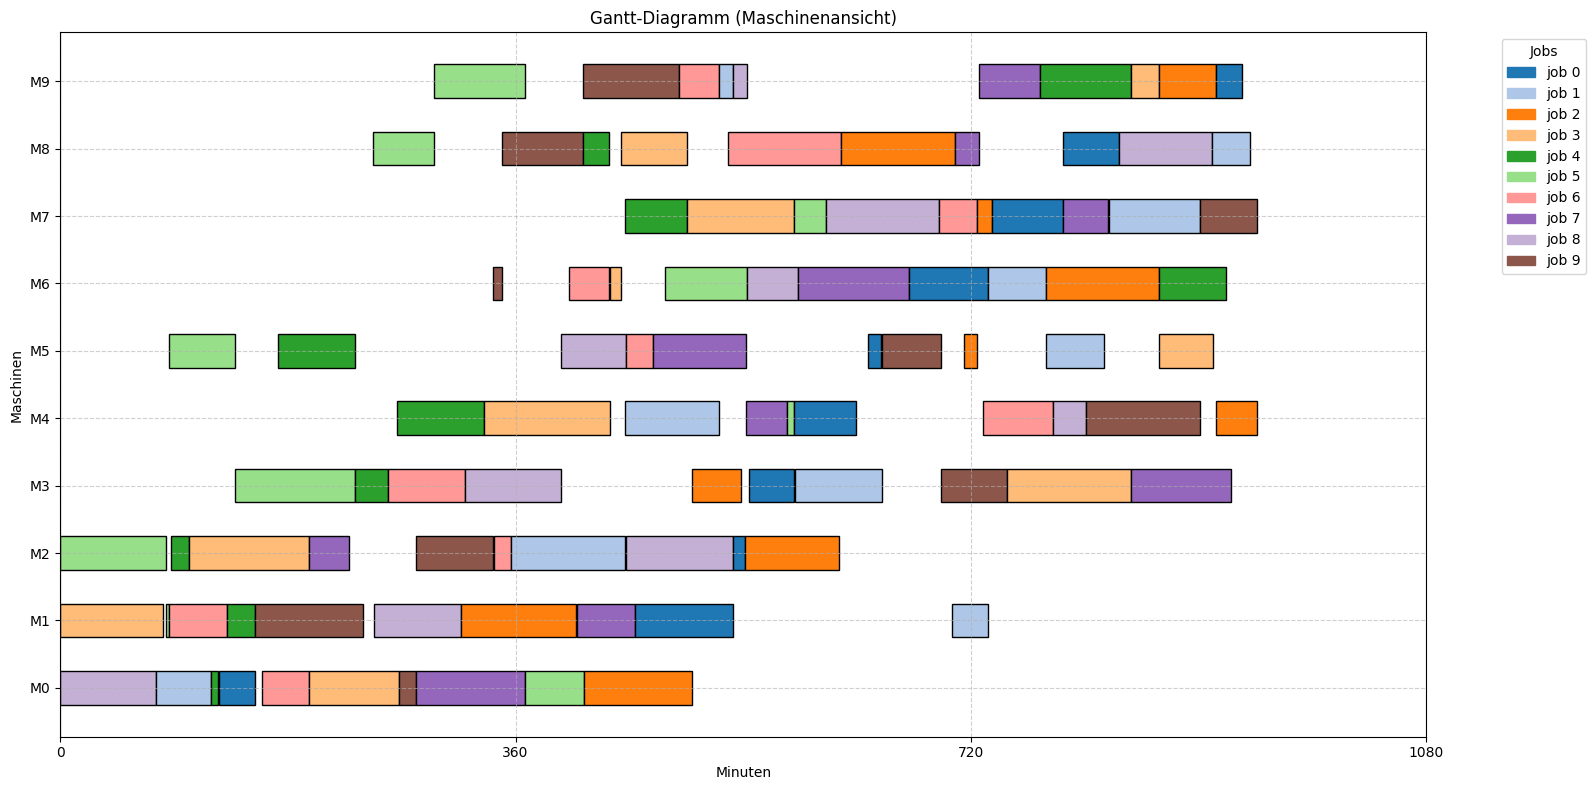

In [11]:
show.plot_gantt_machines(df_plan)

In [12]:
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
- 1 Verletzung(en) der technologischen Reihenfolge gefunden:
  Job 'job 8', Operation 5: Start=532, aber vorherige Operation endete erst bei 532


False

### b) HiGHS mit PuLP

> high performance serial and parallel solver

In [ ]:
starting_time = time.time()

# Scheduling
df_plan = solve_jssp_makespan(df_instance, solver= "HiGHS", msg=False, time_limit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.1f} Sekunden.")
df_plan

BigM: 24000


In [ ]:
show.plot_gantt_jobs(df_plan)

In [ ]:
show.plot_gantt_machines(df_plan)

In [ ]:
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)